In [24]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import numpy as np
import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

print(jax.devices())
jax.config.update("jax_enable_x64", True)

sys.path.append('../../')

from cofilin.forward_model.fourier import my_ifft, my_fft, get_k, get_k_nyq, get_k_1D, get_k_rfft_1D
from cofilin.forward_model.fourier_aux import make_rfft3_arr_from_N_cube_numbers, make_N_cube_numbers_from_rfft3_arr
from cofilin.forward_model.config import FMConfig, Constants
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.cosmo import compute_or_load_pow_spec_cube
from cofilin.forward_model.ics import gen_input_arr, get_delta_in
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[cuda(id=0)]


vemos un 0.5% de std mayor pero cambia con distintas realizaciones asumimos que esta bien.

In [18]:
N, L, Z_I, Z_F = 64, 500, 99, 0
cte = Constants(N, L, Z_I, Z_F)

key = jax.random.PRNGKey(4)

fm_cfg_cwn = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    lpt_method="1LPT",
    input_kind="CWN",
)
fmodel_cwn = FModel(fm_cfg_cwn)
input_arr_cwn = gen_input_arr(key, cte, fm_cfg_cwn)
din_cwn_hat = fmodel_cwn.delta_in(input_arr_cwn)
din_cwn = my_ifft(din_cwn_hat, cte.INV_L3)

N_TR is not set. No bias in forward model.


In [40]:
input_arr_cwn_rfft = make_rfft3_arr_from_N_cube_numbers(input_arr_cwn, cte.N)
din_cwn_hat_2 = input_arr_cwn_rfft * jnp.sqrt(fm_cfg_cwn.pow_spec * cte.L3 * 0.5)

print(jnp.all(jnp.isclose(din_cwn_hat, din_cwn_hat_2)))

one_over_pk = jnp.where(fm_cfg_cwn.pow_spec != 0, 1 / (fm_cfg_cwn.pow_spec), 1)

input_arr_cwn_rfft_2 = din_cwn_hat_2

True


In [75]:
one_over_pk = jnp.where(fm_cfg_cwn.pow_spec != 0, 1 / (fm_cfg_cwn.pow_spec), 1.)
input_arr_cwn_2 = make_N_cube_numbers_from_rfft3_arr(din_cwn_hat*jnp.sqrt(one_over_pk), N )* jnp.sqrt(2*cte.INV_L3)

print(input_arr_cwn[:10, 0,0])
print(input_arr_cwn_2[:10, 0,0])
is_equal = jnp.isclose(input_arr_cwn, input_arr_cwn_2)
print(jnp.sum(is_equal))
print(N**3)

print(jnp.where(is_equal!=1))

print(input_arr_cwn[62, 0,0])
print(input_arr_cwn_2[62, 0,0])
print(fm_cfg_cwn.pow_spec[62, 0,0])
print(one_over_pk[62, 0,0])

[ 1.29121214 -1.34142401  0.54115113 -0.51117993  1.45639534  0.92102196
 -0.76774857  0.06155014 -0.46812272 -0.61640221]
[ 1.29121217 -1.34142391  0.54115111 -0.51117988  1.45639518  0.92102195
 -0.76774855  0.06155014 -0.46812268 -0.6164022 ]
262143
262144
(Array([62], dtype=int64), Array([0], dtype=int64), Array([0], dtype=int64))
-1.2349853073695556
-0.0
3.54745
0.28189263


In [72]:
a = make_N_cube_numbers_from_rfft3_arr(din_cwn_hat, N)
din_cwn_hat2 = make_rfft3_arr_from_N_cube_numbers(a, N)


print(din_cwn_hat[:3, 0,0])
print(din_cwn_hat2[:3, 0,0])
is_equal = jnp.isclose(din_cwn_hat, din_cwn_hat2)
print(jnp.all(is_equal))
print(jnp.sum(is_equal))
print(N**3//2+-4)

[   -0.            +0.j          5884.90914291-12952.57432528j
 -3211.01232427+15948.57941734j]
[   -0.            +0.j          5884.90914291-12952.57432528j
 -3211.01232427+15948.57941734j]
True
135168
131068


In [29]:
q = gen_input_arr(key, cte, fm_cfg_cwn)
q_rfft = make_rfft3_arr_from_N_cube_numbers(q, N)
q_2 = make_N_cube_numbers_from_rfft3_arr(q_rfft, N)

print(q[:10, 0,0])
print(q_2[:10, 0,0])
print(jnp.all(jnp.isclose(q, q_2)))

[ 1.29121214 -1.34142401  0.54115113 -0.51117993  1.45639534  0.92102196
 -0.76774857  0.06155014 -0.46812272 -0.61640221]
[ 1.29121214 -1.34142401  0.54115113 -0.51117993  1.45639534  0.92102196
 -0.76774857  0.06155014 -0.46812272 -0.61640221]
True


In [20]:
print(input_arr_cwn[:10, 0,0])
print(input_arr_cwn_2[:10, 0,0])

[ 1.29121214 -1.34142401  0.54115113 -0.51117993  1.45639534  0.92102196
 -0.76774857  0.06155014 -0.46812272 -0.61640221]
[ 0.66384498 -0.92141833  0.48737548 -0.62982371  2.2957183   1.77006595
 -1.84532842  0.17699365 -1.62334079 -2.56629985]


In [ ]:
input_arr_cwn = make_rfft3_arr_from_N_cube_numbers(input_arr_wn, N)
# a = my_ifft(input_arr_wn, cte.INV_L3)



In [ ]:
# input_arr_wn = gen_input_arr(key, cte, fm_cfg_wn)
# input_arr_cwn = make_rfft3_arr_from_N_cube_numbers(input_arr_wn, N)

# input_arr_wn_hat = my_fft(input_arr_wn, cte.L3)

# cwn_2 = input_arr_cwn *cte.L3 / jnp.sqrt(cte.N3) / jnp.sqrt(2) 

# # print(jnp.std(input_arr_cwn)*cte.L3 / jnp.sqrt(cte.N3) / jnp.sqrt(2))
# # print(jnp.std(input_arr_wn_hat))

# jnp.isclose(cwn_2.real, input_arr_wn_hat.real, atol=)



Array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

pk_cube is not None, forcing no cross


(0.1, 4.0)

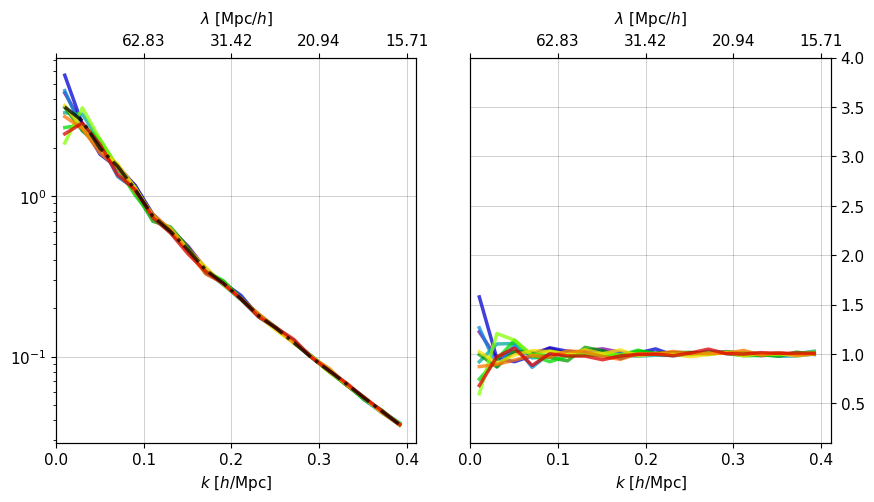

In [4]:
pk_cube = fm_cfg.pow_spec

key_amp = jax.random.PRNGKey(1)

M = 10
sks_amp = jax.random.split(key_amp, M)
dins = []

for i in range(M):
    amp_arr = gen_input_arr(sks_amp[i], cte, fm_cfg)
    din = my_ifft(fmodel.delta_in(amp_arr), cte.INV_L3)
    dins.append(din)


fig, axs = compare_pow_spec(
    dins,
    L,
    n_bins=20,
    pk_cube=pk_cube,
    no_labels=True,
    sphere_only=True,
)
axs[1].set_ylim(0.1, 4)

(<Figure size 500x500 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

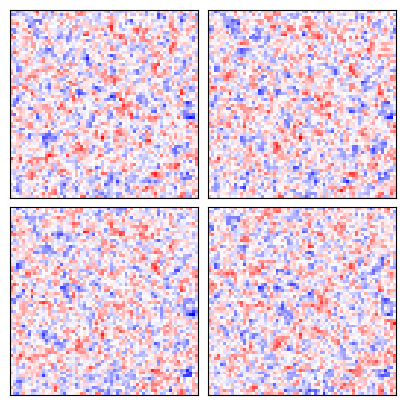

In [5]:
plot_cubes(dins[:4], vlim=1e-1)